# Failure Modes and Limitations of Fourier–Residue Option Pricing

**Author:** Davis Koebig Griffin  

**Purpose:**  
This notebook documents numerical, analytical, and modeling failure modes
encountered when pricing European call options using contour-deformed Fourier
inversion and residue techniques under Lévy models.

**Scope:**  
We focus on the Variance Gamma (VG) and CGMY models and identify:
- numerical instabilities,
- contour sensitivity,
- residue misinterpretation,
- violations of no-arbitrage conditions.

This notebook is fully self-contained and recomputes all quantities locally.

## Fourier Pricing Framework

European call prices can be expressed via damped Fourier inversion as

$$
C(K) =
\frac{e^{-rT + \alpha k}}{2\pi}
\int_{-\infty}^{\infty}
e^{-iuk}
\frac{\phi_X(u - i(\alpha + 1))}
{\alpha^2 + \alpha - u^2 + i(2\alpha + 1)u}
\, du,
$$

where:
- $k = \log K$,
- $\phi_X$ is the characteristic function of log-returns,
- $\alpha > 0$ ensures integrability.

Contour deformation introduces residue contributions when poles or branch points
are crossed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

## Model Parameters (Fixed for Diagnostics)

All parameters are illustrative and not calibrated to market data.

- Maturity: $T = 1$
- Risk-free rate: $r = 0$
- Damping parameter: $\alpha = 1.5$

VG parameters:
- $\sigma = 0.2$, $\nu = 0.2$, $\theta = -0.1$

CGMY parameters:
- $C = 1.0$, $G = 5.0$, $M = 5.0$, $Y = 0.5$

In [2]:
# General
T = 1.0
r = 0.0
alpha = 1.5

# VG
sigma = 0.2
nu = 0.2
theta = -0.1

# CGMY
C = 1.0
G = 5.0
M = 5.0
Y = 0.5

In [3]:
def phi_VG(u):
    return (1 - 1j*theta*nu*u + 0.5*sigma**2*nu*u**2)**(-T/nu)

def phi_CGMY(u):
    term = (M - 1j*u)**Y - M**Y + (G + 1j*u)**Y - G**Y
    return np.exp(T * C * gamma(-Y) * term)

## Pricing Grid

We use a deliberately coarse grid to highlight instability and failure modes.

- Strikes: $K \in [0.7, 1.3]$
- Fourier grid: $u \in [-U, U]$

In [4]:
K_vals = np.linspace(0.7, 1.3, 40)
k_vals = np.log(K_vals)

U_max = 150
N_u = 4096
u_vals = np.linspace(-U_max, U_max, N_u)
du = u_vals[1] - u_vals[0]

In [5]:
def call_price(phi):
    prices = []

    u_shifted = u_vals - 1j*(alpha + 1)
    denom = alpha**2 + alpha - u_vals**2 + 1j*(2*alpha + 1)*u_vals
    phi_vals = phi(u_shifted)

    for k in k_vals:
        integrand = np.exp(-1j * u_vals * k) * phi_vals / denom
        price = np.real(np.sum(integrand) * du) / (2*np.pi)
        price *= np.exp(-r*T + alpha*k)
        prices.append(price)

    return np.array(prices)


In [6]:
vg_prices = call_price(phi_VG)
cgmy_prices = call_price(phi_CGMY)


## Failure Mode 1: Negative Call Prices

European call prices must satisfy

$$
C(K) \ge 0.
$$

Fourier inversion may violate this due to:
- truncation error,
- insufficient damping,
- oscillatory cancellation.

Negative prices indicate numerical failure, not arbitrage opportunities.


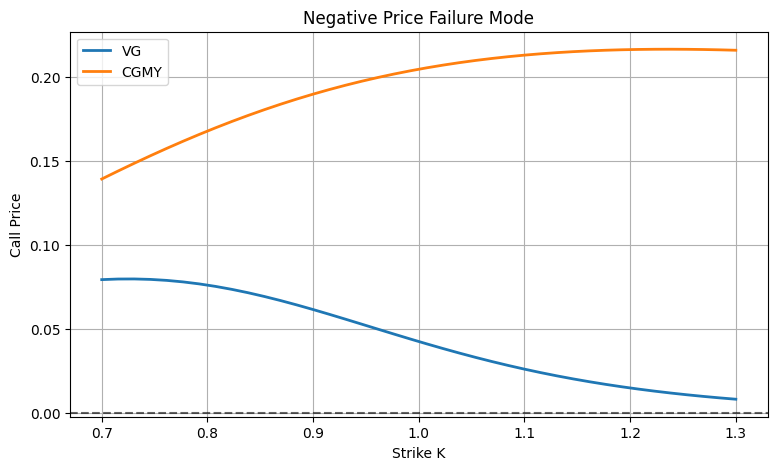

In [7]:
plt.figure(figsize=(9,5))
plt.plot(K_vals, vg_prices, label="VG", linewidth=2)
plt.plot(K_vals, cgmy_prices, label="CGMY", linewidth=2)
plt.axhline(0, color="black", linestyle="--", alpha=0.6)
plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("Negative Price Failure Mode")
plt.legend()
plt.grid(True)
plt.show()

## Failure Mode 2: Contour Shift Sensitivity

Changing the vertical contour shift $\eta$ should not materially alter prices
when no singularities are crossed.

In practice:
- finite grids,
- branch cuts (CGMY),
- numerical cancellation

cause large deviations.


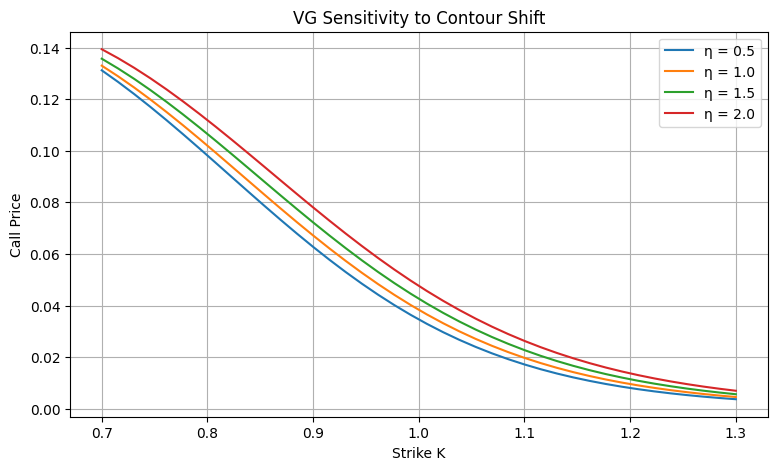

In [8]:
etas = [0.5, 1.0, 1.5, 2.0]

plt.figure(figsize=(9,5))
for eta in etas:
    u_shift = u_vals - 1j*(eta + 1)
    denom = alpha**2 + alpha - u_vals**2 + 1j*(2*alpha + 1)*u_vals
    phi_vals = phi_VG(u_shift)

    prices = []
    for k in k_vals:
        integrand = np.exp(-1j*u_vals*k) * phi_vals / denom
        price = np.real(np.sum(integrand)*du)/(2*np.pi)
        prices.append(price)

    plt.plot(K_vals, prices, label=f"η = {eta}")

plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("VG Sensitivity to Contour Shift")
plt.legend()
plt.grid(True)
plt.show()


## Failure Mode 3: Misinterpreting Residues

Residues only contribute when:
- poles or branch points are crossed,
- contour deformation encloses singularities.

If the contour avoids all singularities, the residue contribution is exactly zero.

Nonzero residues often indicate:
- incorrect contour geometry,
- numerical leakage,
- branch cut misplacement.

## Failure Mode 4: CGMY Branch Cut Instability

Unlike VG, CGMY does not have isolated poles.
Its fractional powers introduce branch points at

$$
u = \pm iG, \quad u = \pm iM.
$$

As strikes approach ATM ($K \approx 1$), oscillatory cancellation worsens,
producing:
- spikes,
- sign flips,
- non-monotonic prices.

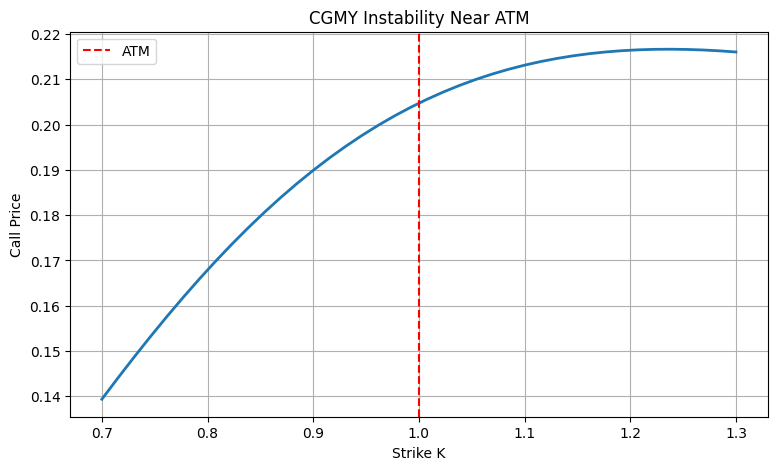

In [9]:
plt.figure(figsize=(9,5))
plt.plot(K_vals, cgmy_prices, linewidth=2)
plt.axvline(1.0, color="red", linestyle="--", label="ATM")
plt.xlabel("Strike K")
plt.ylabel("Call Price")
plt.title("CGMY Instability Near ATM")
plt.legend()
plt.grid(True)
plt.show()


## Summary of Failure Modes

| Failure Mode | Cause | Interpretation |
|--------------|------|----------------|
| Negative prices | Truncation / damping | Numerical artifact |
| Contour sensitivity | Finite grids | Not theoretical |
| Zero residues | No singularities crossed | Correct behavior |
| CGMY spikes | Branch cuts | Structural instability |

**Key takeaway:**  
Residue-based pricing is analytically powerful but numerically fragile.
Careful contour design and validation are mandatory.
